In [107]:
#import libraries that may be needed in the course of the work
import pandas as pd
import numpy as np
import math
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import calendar

%matplotlib inline

In [108]:
#upload files
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/Ilya_Levin/csv_for_projects/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/Ilya_Levin/csv_for_projects/olist_orders_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/Ilya_Levin/csv_for_projects/olist_order_items_dataset.csv')

In [109]:
#Convert dates to required format
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

In [110]:
# First, let's understand what can be considered as a purchase. To do this, we examine the data.
# It is immediately evident that if there is no order confirmation time, the order is not paid
# Check order statuses where there is no order confirmation date

In [111]:
orders.query('order_approved_at == "NaT"').groupby('order_status', as_index=False).agg({'order_id' : 'count'})

,order_status,order_id
0,canceled,141
1,created,5
2,delivered,14


In [112]:
# Also count the number of orders in all statuses

In [113]:
orders.groupby('order_status', as_index=False).agg({'order_id' : 'count'})

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [114]:
# Based on the two tables received, I conclude that I consider unpaid orders with a missing confirmation date
# And also all the others with the statuses "canceled" and "unavailable"
# Create a table with completed orders

In [115]:
success_orders = orders.query('order_approved_at != "NaT"').query('order_status != "canceled" and order_status != "unavailable"')

In [116]:
#Check
success_orders.groupby('order_status', as_index=False).agg({'order_id' : 'count'})

,order_status,order_id
0,approved,2
1,delivered,96464
2,invoiced,314
3,processing,301
4,shipped,1107


In [117]:
# unavailable - clearly undelivered items that would not be considered a purchase
# canceled - canceled order. Moreover, you can cancel it at any stage, even after the order has been delivered.

In [118]:
# 1. How many users do we have who have made a purchase only once?
# to answer this question, we need to join two tables orders and customers by customer_id

In [119]:
customers_orders = customers.merge(orders, how='inner', left_on='customer_id', right_on='customer_id')

In [120]:
# Let's calculate who made how many purchases by applying the filter from success_orders.
# Just in case, we will calculate by customer_id and order_id
amount_of_orders = customers_orders \
    .query('order_approved_at != "NaT"').query('order_status != "canceled" and order_status != "unavailable"') \
    .groupby('customer_unique_id', as_index=False).agg({'customer_id' : 'count', 'order_id' : 'count'}) \
    .sort_values('customer_id', ascending=False)

In [121]:
# now logically check if the number of orders by order_id and customer_id is identical

In [122]:
amount_of_orders.query('customer_id == 1').shape[0]

92087

In [123]:
amount_of_orders.query('order_id == 1').shape[0]

92087

In [124]:
amount_of_orders.query('order_id == 1').customer_unique_id.nunique()

92087

In [125]:
# the guess is correct. the number of purchases can be counted both by order_id and customer_id
# 1. How many users do we have who have made a purchase only once? - ANSWER: 92087

In [126]:
# 2. How many orders per month, on average, are not delivered for various reasons (display details by reason)?
# Consider orders with "canceled" and "unavailable" statuses, and take the month from order_estimated_delivery_date

In [127]:
orders['estimated_delivery_date'] = orders.order_estimated_delivery_date.dt.to_period('M')

In [128]:
undelivered_orders = orders.query('order_status == "canceled" or order_status == "unavailable"') \
    .groupby(['order_status', 'estimated_delivery_date'], as_index=False) \
    .agg({'order_id' : 'count'}) \
    .pivot(index='estimated_delivery_date', columns='order_status', values='order_id').reset_index().fillna(0)

In [129]:
# 2. How many orders per month, on average, are not delivered for various reasons (display details by reason)?
# The answer is in the undelivered_orders table. We found two reasons
# Due to "canceled" - the arithmetic mean is 24 orders per month, and the median is 23 orders per month.
# Due to "unavailable" - the arithmetic mean is 23 orders per month, and the median is 18 orders per month

order_status,canceled,unavailable
count,26.000000,26.000000
mean,24.038462,23.423077
std,20.322364,22.712416
min,1.000000,0.000000
25%,11.250000,2.750000
50%,22.500000,17.500000
75%,28.500000,38.750000
max,88.000000,72.000000


In [130]:
undelivered_orders.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/first_project/q2_undelivered_orders.csv', sep=',')

In [131]:
# 3. For each product, determine on what day of the week the product is most often bought?
# First we need to join two tables orders and items by order_id and filter by completed purchases

In [132]:
items_orders = items.merge(orders, how='inner', left_on='order_id', right_on='order_id')

In [133]:
items_orders = items_orders.query('order_approved_at != "NaT"').query('order_status != "canceled" and order_status != "unavailable"')

In [134]:
# Define the day of the week for each purchase date

In [135]:
items_orders['weekday'] = items_orders.order_purchase_timestamp.dt.day_name()

In [136]:
products_weekday = items_orders.groupby(['product_id', 'weekday'], as_index=False).agg({'order_id' : 'count'})

In [137]:
# Got a table with the number of sales of each product by day
products_weekday

,product_id,weekday,order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60876,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60877,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60878,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60879,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [138]:
# Let's make a table with the maximum sales for each product
max_values = products_weekday.groupby('product_id', as_index=False).max('order_id').rename(columns={'order_id' : 'max_value'})

In [139]:
max_values

,product_id,max_value
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32721,fff6177642830a9a94a0f2cba5e476d1,1
32722,fff81cc3158d2725c0655ab9ba0f712c,1
32723,fff9553ac224cec9d15d49f5a263411f,1
32724,fffdb2d0ec8d6a61f0a0a0db3f25b441,2


In [140]:
# Now join two tables by product_id and max sales value so that only those days of the week remain \
# when sales were at their highest, even if there were several days of the week
a = max_values.merge(products_weekday, how='inner', left_on=['product_id', 'max_value'], right_on=['product_id', 'order_id'])

In [141]:
a = a.drop(columns=['order_id'])

In [142]:
# Sort the table by the highest sales values. final table - q3_orders_per_weekdays.
a = a.sort_values('max_value')
q3_orders_per_weekdays = a
q3_orders_per_weekdays.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/first_project/q3_orders_per_weekdays.csv', sep=',')

In [143]:
q3_orders_per_weekdays

,product_id,max_value,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,1,Sunday
26242,9fa383a47388caa20228a1b5e238472b,1,Monday
26241,9fa1e97015f5c5e76add50079bb0ab44,1,Wednesday
26240,9fa1e97015f5c5e76add50079bb0ab44,1,Tuesday
26239,9fa1e97015f5c5e76add50079bb0ab44,1,Monday
...,...,...,...
9385,389d119b48cf3043d311335e499d9c6b,67,Thursday
13894,53b36df67ebb7c41585e8d54d6772e08,76,Tuesday
28301,aca2eb7d00ea1a7b8ebd4e68314663af,89,Thursday
25234,99a4788cb24856965c36a24e339b6058,92,Monday


In [144]:
# 4. How many purchases does each user have on average per week (by months)?

In [145]:
# Filter by successful purchases only
suc_customers_orders = customers_orders \
    .query('order_approved_at != "NaT"').query('order_status != "canceled" and order_status != "unavailable"')

In [146]:
# Convert the date of purchase to year-month format
suc_customers_orders.order_purchase_timestamp = suc_customers_orders.order_purchase_timestamp.dt.to_period('M')

In [147]:
# Calculate the number of purchases of each client by date (year-month)
mean_orders_per_week = suc_customers_orders.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False).agg({'order_id' : 'count'}).sort_values('order_id').reset_index().drop(columns=['index'])

In [148]:
# Next, determine the number of days in the month in which the purchase was made
# In this case, I considered a little roundabout, since I could not pass the row number to the argument, so I duplicated the indices into the column in order to use them as arguments
# so I will be glad if you tell me how to make the code shorter
# To begin with, we will make columns with the year and month number, in advance under the necessary function we will make a column with the number of days per month, where we will pass the row number
mean_orders_per_week['year_of_purchase'] = mean_orders_per_week.order_purchase_timestamp.dt.year
mean_orders_per_week['month_of_purchase'] = mean_orders_per_week.order_purchase_timestamp.dt.month
mean_orders_per_week['days_in_month'] = mean_orders_per_week.index

In [149]:
# Find the number of days depending on the year and month
mean_orders_per_week['days_in_month'] = mean_orders_per_week['days_in_month'].apply(lambda x: calendar.monthrange(mean_orders_per_week['year_of_purchase'][x],mean_orders_per_week['month_of_purchase'][x])[1])

In [150]:
# find the number of weeks in a month and find the average value of purchases per week in each year-month
mean_orders_per_week['weeks_in_month'] = mean_orders_per_week.days_in_month / 7
mean_orders_per_week['mean_orders_per_week'] = mean_orders_per_week.order_id / mean_orders_per_week.weeks_in_month

In [151]:
# In view of the fact that when calculating the average, we do not need a year, but only a month (seasonality), we will group by customers and month number with taking the average from the averages, which will give us exactly the averages by months
final_mean_orders_per_week = mean_orders_per_week.groupby(['customer_unique_id', 'month_of_purchase'], as_index=False).agg({'mean_orders_per_week' : 'mean'}).sort_values('customer_unique_id')

In [152]:
# Convert the month number to its name
final_mean_orders_per_week['month_of_purchase'] = final_mean_orders_per_week['month_of_purchase'].apply(lambda x: calendar.month_abbr[x])

In [153]:
# 4. How many purchases does each user have on average per week (by months)? - ANSWER:
final_mean_orders_per_week.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/first_project/q4_final_mean_orders_per_week.csv', sep=',')

In [154]:
final_mean_orders_per_week

,customer_unique_id,month_of_purchase,mean_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,0.225806
2,0000f46a3911fa3c0805444483337064,Mar,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,Oct,0.225806
4,0004aac84e0df4da2b147fca70cf8255,Nov,0.233333
...,...,...,...
96802,fffcf5a5ff07b0908bd4e2dbc735a684,Jun,0.233333
96803,fffea47cd6d3cc0a88bd621562a9d061,Dec,0.225806
96804,ffff371b4d645b6ecea244b27531430a,Feb,0.250000
96805,ffff5962728ec6157033ef9805bacc48,May,0.225806


In [155]:
# 5. Using pandas, conduct a cohort analysis of users.
# Between January and December, identify the cohort with the highest retention for the 3rd month.
# Let's work with customers_orders. We leave only successful purchases.

In [156]:
success_customers_orders = customers_orders.query('order_approved_at != "NaT"') \
                            .query('order_status != "canceled" and order_status != "unavailable"') \
                            .reset_index().drop(columns=['index'])

In [157]:
# Determine the date of the first purchase for each customer
first_orders = success_customers_orders.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'min'}) \
                                        .rename(columns={'order_purchase_timestamp' : 'first_order'})

In [158]:
# convert the column with the date of the first purchase to the year-month format
first_orders.first_order = first_orders.first_order.dt.strftime('%Y-%m')

In [159]:
# add data with the first purchase to the main dataframe by merge
cus_orders_murged = success_customers_orders.merge(first_orders, how='inner', left_on='customer_unique_id', right_index=True)

In [160]:
# convert the column with the purchase date to year-month format
cus_orders_murged.order_purchase_timestamp = cus_orders_murged.order_purchase_timestamp.dt.strftime('%Y-%m')

In [161]:
# rename column with purchase date
cus_orders_murged = cus_orders_murged.rename(columns={'order_purchase_timestamp' : 'order_period'})

In [162]:
# we build cohorts by the number of orders and the number of customers
cohorts = cus_orders_murged.groupby(['first_order','order_period']) \
                           .agg({'order_id' : 'count', 'customer_unique_id' : pd.Series.nunique})

In [163]:
# Add the ordinal value of the order date for each cohort, for which we will define a function.
# CohortPeriod is defined as the ordinal number of the month in the array starting from 1
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [164]:
# Apply the function to the table with cohorts
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [165]:
# Rename columns for convenience
cohorts = cohorts.rename(columns={'order_id' : 'total_orders', 'customer_unique_id' : 'total_clients'})

In [166]:
# To calculate retention as a percentage, set the initial size of each cohort
cohort_group_size = cohorts['total_clients'].groupby(level=0).first()

In [167]:
# Rearrange the ordinal value of the order date for each cohort into indices
cohorts.reset_index(inplace=True)
cohorts.set_index(['first_order','CohortPeriod'], inplace=True)

In [168]:
# Expand the table and look at customer retention in absolute values
cohorts['total_clients'].unstack(1).head(15)

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,290.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,750.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN


In [169]:
# And now we divide the absolute values by the size of the cohort to see the percentage of retention
# For the third month, the cohort of clients who came in September 2017 has the highest retention
user_retention = cohorts['total_clients'].unstack(1).divide(cohort_group_size, axis=0) * 100
user_retention.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/first_project/q5_user_retention.csv', sep=',')

In [170]:
user_retention

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,0.344828,0.344828,0.344828,0.344828,0.344828,0.344828,0.689655,0.689655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,100.0,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.400000,0.266667,0.133333,0.400000,0.133333,0.400000,0.133333,0.133333,0.400000,0.133333,0.666667,0.400000,0.133333,0.133333,0.266667,0.400000,0.133333
2017-02,100.0,0.238379,0.297974,0.119190,0.417163,0.119190,0.238379,0.178784,0.059595,0.178784,0.119190,0.297974,0.119190,0.178784,0.119190,0.059595,0.059595,0.238379
2017-03,100.0,0.505640,0.350058,0.388954,0.350058,0.155581,0.155581,0.311163,0.350058,0.077791,0.388954,0.116686,0.233372,0.116686,0.155581,0.233372,0.077791,0.155581
2017-04,100.0,0.602151,0.215054,0.172043,0.301075,0.258065,0.344086,0.301075,0.301075,0.172043,0.258065,0.086022,0.086022,0.043011,0.086022,0.086022,0.129032,NaN
2017-05,100.0,0.480090,0.480090,0.395369,0.310647,0.338887,0.423609,0.141203,0.254165,0.254165,0.254165,0.338887,0.254165,0.028241,0.197684,0.225925,NaN,NaN
2017-06,100.0,0.451322,0.354610,0.386847,0.257898,0.386847,0.354610,0.225661,0.128949,0.225661,0.322373,0.322373,0.161186,0.128949,0.193424,NaN,NaN,NaN


In [171]:
# 6. Using python, build an RFM user segmentation
# R - time from the user's last purchase to the current date
# F - the total number of purchases from the user for all time
# M - amount of purchases for all time
# Determine the date of the last purchase for each customer

In [172]:
last_orders = success_customers_orders.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}) \
                                        .rename(columns={'order_purchase_timestamp' : 'last_order'})

In [173]:
R_customers_orders = success_customers_orders.merge(last_orders, how='inner', left_on='customer_unique_id', right_index=True)

In [174]:
R_customers_orders.last_order = pd.to_datetime(R_customers_orders.last_order, format='%Y-%m-%d')

In [175]:
# Find how many days ago the last purchase was made. We will count from the date following the date of the last purchase
# The last purchase was made on September 3, 2018, so we will count from September 4, 2018

In [176]:
last_day = datetime.date(2018, 9, 4)

In [177]:
R_customers_orders['last_day'] = pd.to_datetime(last_day)

In [178]:
R_customers_orders['days_delta'] = pd.to_timedelta(R_customers_orders.last_day - R_customers_orders.last_order).dt.days

In [179]:
R_customers_orders.groupby('days_delta').agg({'customer_unique_id' : 'count'}).sort_values('days_delta')

,customer_unique_id
days_delta,
0,2
5,11
6,43
7,70
8,75
...,...
698,40
699,57
700,6


In [180]:
# As you can see, there are customers who last bought 729 days ago.
# Independently determine the boundaries for the criterion R
# from 0 to 30 days - 3 points, 30 - 180 days - 2 points, more than 180 days - 1 point

In [181]:
def function_r(R_customers_orders):
    R = 0
    if R_customers_orders["days_delta"] <=30:
        R = 3
    elif 30 < R_customers_orders["days_delta"] <=180:
        R=2
    else:
        R=1
    return (R)

In [182]:
R_customers_orders['R'] = R_customers_orders.apply(function_r, axis=1)

In [183]:
R_customers_orders.groupby('R').agg({'customer_unique_id' : 'count'}).sort_values('R')

,customer_unique_id
R,
1,59205
2,33296
3,5687


In [184]:
# R criterion added to table
R_customers_orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,last_order,last_day,days_delta,R
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:05:35,2018-09-04,475,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:48:24,2018-09-04,234,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19 16:07:45,2018-09-04,107,2
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 16:06:38,2018-09-04,174,2
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 09:51:30,2018-09-04,36,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98183,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-07 15:48:17,2018-09-04,149,2
98184,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-04 08:20:22,2018-09-04,152,2
98185,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04-08 20:11:50,2018-09-04,148,2
98186,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-03 21:08:33,2018-09-04,304,1


In [185]:
# Determine the total number of purchases from the user for the entire time - F-criterion
# first, let's see what range the number of purchases lies in

In [186]:
R_customers_orders.groupby('customer_unique_id', as_index=False).agg({'order_id' : 'count'}) \
    .sort_values('order_id', ascending=False) \
    .groupby('order_id', as_index=False).agg({'customer_unique_id' : 'count'}) \
    .sort_values('order_id', ascending=False) \
    .rename(columns={'order_id' : 'amount_of_orders', 'customer_unique_id' : 'amount_of_customers'})

,amount_of_orders,amount_of_customers
8,16,1
7,9,1
6,7,3
5,6,5
4,5,9
3,4,29
2,3,188
1,2,2650
0,1,92087


In [187]:
# The number of user purchases varies from 1 to 16 purchases. and there are not so many buyers who have made more than 5 purchases
# Independently determine the boundaries for the criterion F
# more than 3 purchases - 3 points, 2-3 purchases - 2 points, 1 purchase - 1 point

In [188]:
F_customers_orders = success_customers_orders.groupby('customer_unique_id').agg({'order_id': 'count'}) \
                                        .rename(columns={'order_id' : 'amount_of_orders'}) \
                                        .sort_values('amount_of_orders', ascending=False)

In [189]:
F_customers_orders

,amount_of_orders
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,16
3e43e6105506432c953e165fb2acf44c,9
1b6c7548a2a1f9037c1fd3ddfed95f33,7
ca77025e7201e3b30c44b472ff346268,7
6469f99c1f9dfae7733b25662e7f1782,7
...,...
564fb2956ed34f0a78c1cc37d731f3d9,1
564f89ca1f5371992bf1fb87a0331ac3,1
564f521732e1fbf5424fa01f0a5d41ff,1


In [190]:
def function_f(F_customers_orders):
    F = 0
    if F_customers_orders["amount_of_orders"] <2:
        F = 1
    elif 2 <= F_customers_orders["amount_of_orders"] <4:
        F=2
    else:
        F=3
    return (F)

In [191]:
F_customers_orders['F'] = F_customers_orders.apply(function_f, axis=1)


In [192]:
# Criteria R and F added to the table
RF_customers_orders = R_customers_orders.merge(F_customers_orders, how='inner', left_on='customer_unique_id', right_index=True)

In [193]:
# Determine the amount of purchases for all time by each client M-criterion
# first, let's work with the items table and sum the purchases by orders

In [194]:
items_price = items.groupby(['order_id']).agg({'price' : 'sum'}).sort_values('price')

In [195]:
# join the table with the purchase amount with our main table

In [196]:
RF_with_prices = RF_customers_orders.merge(items_price, how='inner', left_on='order_id', right_index=True)

In [197]:
total_sum = RF_with_prices.groupby('customer_unique_id').agg({'price': 'sum'}) \
                                        .rename(columns={'price' : 'total_sum'}) \
                                        .sort_values('total_sum', ascending=False)
                                    

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


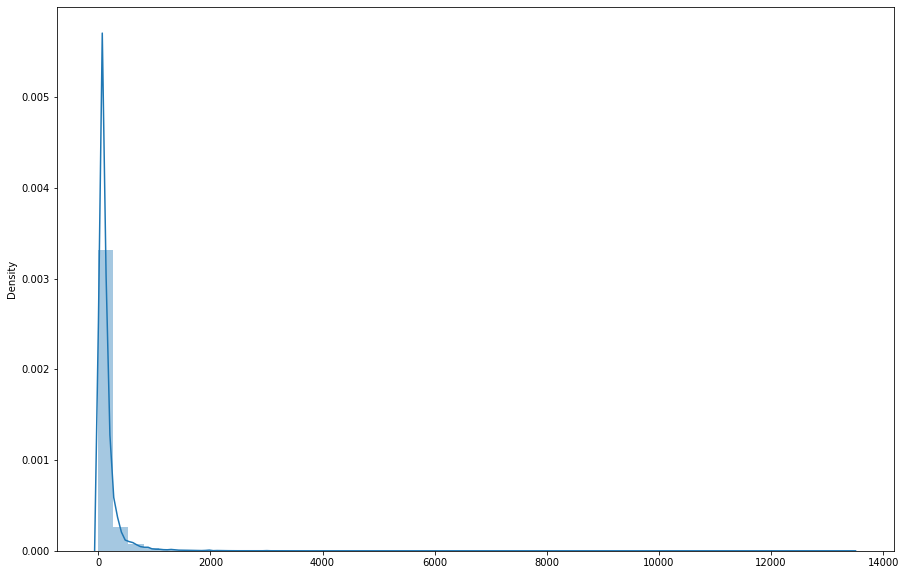

In [198]:
# look at the distribution of sums
plt.figure(figsize=(15, 10))
sns.distplot(total_sum)

In [199]:
total_sum

,total_sum
customer_unique_id,
0a0a92112bd4c708ca5fde585afaa872,13440.00
da122df9eeddfedc1dc1f5349a1a690c,7388.00
763c8b1c9c68a0229c42c9fc6f662b93,7160.00
dc4802a71eae9be1dd28f5d788ceb526,6735.00
459bef486812aa25204be022145caa62,6729.00
...,...
cf3839da0d9492ad151690b65f45d800,2.99
bd06ce0e06ad77a7f681f1a4960a3cc6,2.29
317cfc692e3f86c45c95697c61c853a6,2.20


In [200]:
total_sum.describe()

,total_sum
count,94970.000000
mean,142.073605
std,216.085833
min,0.850000
25%,47.900000
50%,89.890000
75%,155.000000
max,13440.000000


In [201]:
# it turned out the range of amounts from 0.85 to 13444 c.u. The main number of values lies in the range from 0 to 1000 c.u.
# 75% of all users paid less than $155. median - 90 c.u.
# use quantiles in ranking M:
# sum < 47.9 (25% quantile) - 1 point, sum in the range 47.9 - 155 c.u. - 2 points, more than $155 - 3 points

In [202]:
def function_m(total_sum):
    M = 0
    if total_sum["total_sum"] <=47.9:
        M = 1
    elif 47.9 < total_sum["total_sum"] < 155:
        M=2
    else:
        M=3
    return (M)

In [203]:
total_sum['M'] = total_sum.apply(function_m, axis=1)

In [204]:
# The M criterion is added to the table. A table was obtained with all three criteria - R, F and M.
RFM_with_prices = RF_with_prices.merge(total_sum, how='inner', left_on='customer_unique_id', right_index=True)

In [205]:
# remove auxiliary columns
RFM = RFM_with_prices.drop(columns=['last_day', 'price'])

In [206]:
# Make transformations to combine RFM scores
RFM.R = RFM.R.astype('str')
RFM.F = RFM.F.astype('str')
RFM.M = RFM.M.astype('str')

In [207]:
RFM.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
last_order                       datetime64[ns]
days_delta                                int64
R                                        object
amount_of_orders                          int64
F                                        object
total_sum                               float64
M                                        object
dtype: object

In [208]:
RFM['RFM'] = RFM.R + RFM.F + RFM.M

In [209]:
RFM.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-levin/first_project/q6_RFM.csv', sep=',')

In [210]:
RFM

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,last_order,days_delta,R,amount_of_orders,F,total_sum,M,RFM
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:05:35,475,1,1,1,124.99,2,112
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:48:24,234,1,1,1,289.00,3,113
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19 16:07:45,107,2,1,1,139.94,2,212
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 16:06:38,174,2,1,1,149.94,2,212
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 09:51:30,36,2,1,1,230.00,3,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98183,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-07 15:48:17,149,2,1,1,74.90,2,212
98184,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-04 08:20:22,152,2,1,1,114.90,2,212
98185,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04-08 20:11:50,148,2,1,1,37.00,1,211
98186,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-03 21:08:33,304,1,1,1,689.00,3,113


In [211]:
RFM.groupby('RFM').agg({'customer_unique_id' : pd.Series.nunique})

,customer_unique_id
RFM,
111,14414
112,28013
113,13306
121,65
122,638
123,945
131,1
132,2
133,13
